In [1]:
from dataset import Dataset
from classificadores import PerceptronSimples, MultiLayerPerceptron, ExtremeLearningMachine

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from IPython.display import clear_output

from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.patches import Rectangle

### Conjunto de dados Câncer de Mama
------

In [2]:
# Conjunto de dados Câncer de Mama =================================================
colunas = ["ID", "Diagnosis", "radius1", "texture1", "perimeter1", "area1", "smoothness1", "compactness1", "concavity1", "concave_points1", "symmetry1", "fractal_dimension1", "radius2", "texture2", "perimeter2", "area2", "smoothness2", "compactness2", "concavity2", "concave_points2", "symmetry2", "fractal_dimension2", "radius3", "texture3", "perimeter3", "area3", "smoothness3", "compactness3", "concavity3", "concave_points3", "symmetry3", "fractal_dimension3"]

dataset = Dataset.from_file( 
    filepath = r"datasets\wdbc.data", 
    label_column = 1,
    delimiter = ",",  
    column_names = colunas
).ensure_numeric_labels().remove_features(["ID"]).normalize()

dataset.vectorize_labels()

print(dataset)

Dataset(instâncias=569, features=30, classes=2)


#### Seleção da taxa de aprendizado e número de épocas

Treinamento encerrado após 300 épocas. Custo = 0.05326748649980387.


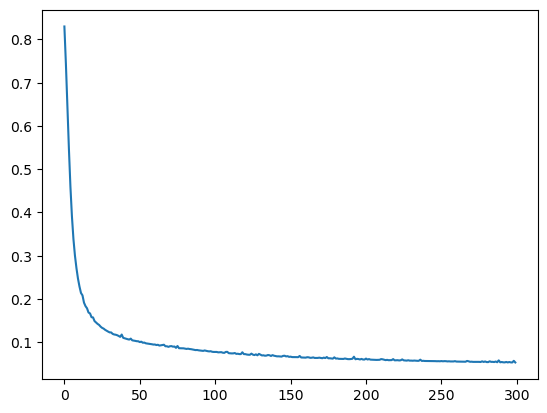

In [4]:
# MLP
train_dataset, test_dataset = dataset.split()
MLP = MultiLayerPerceptron( train_dataset, q = 3 )

Js = MLP.train( max_epocas = 300, eta = 0.003 )

i, J = zip( *Js )
plt.plot(i, J)

#### Classificação

In [5]:
# Dicionários para armazenar as acurácias
acuracia_teste = {
    "PS": [], "MLP": [], "ELM": []
}

acuracia_treinamento = {
    "PS": [], "MLP": [], "ELM": []
}

# Dicionários com as matrizes de confusão
matriz_confusão_treinamento = {
    "PS":  np.zeros( shape = (dataset.class_count, dataset.class_count) ), 
    "MLP": np.zeros( shape = (dataset.class_count, dataset.class_count) ), 
    "ELM": np.zeros( shape = (dataset.class_count, dataset.class_count) )
}

matriz_confusão_teste = {
    "PS":  np.zeros( shape = (dataset.class_count, dataset.class_count) ), 
    "MLP": np.zeros( shape = (dataset.class_count, dataset.class_count) ), 
    "ELM": np.zeros( shape = (dataset.class_count, dataset.class_count) )
}

In [6]:
# Percorre as rodada independentes
nRodadas = 50

for rodada in range( nRodadas ):
    print(f"\n==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== {rodada+1}/{nRodadas}")

    # Para cada rodada independente, realiza o shuffle e separa o conjunto de dados
    shuffled_dataset = dataset.shuffle()
    train_dataset, test_dataset = shuffled_dataset.split()

    # Cria instâncias para os classificadores
    PS = PerceptronSimples( train_dataset )
    MLP = MultiLayerPerceptron( train_dataset, q = 3 )
    ELM = ExtremeLearningMachine( train_dataset, q = 20 )

    # Treina cada uma das redes
    print("Treinando o PS:")
    PS.train( max_epocas = 100, eta = 0.01 )

    print("\nTreinando o MLP:")
    MLP.train( max_epocas = 300, eta = 0.003 )

    print("\nTreinando o ELM")
    ELM.train()

    # Reseta os erros em cada rodada
    erros_treinamento = {
        "PS": 0, "MLP": 0, "ELM": 0
    }

    erros_teste = {
        "PS": 0, "MLP": 0, "ELM": 0
    }    

    #  Percorre o conjunto de treinamento e computa os erros
    for index, *features, classe_correta in train_dataset:

        # Preenche os dicionários de erros e as matrizes de confusão
        for nome, classificador in [("PS", PS), ("MLP", MLP), ("ELM", ELM)]:
            classe_predita = classificador.predict( features )
            if classe_predita != classe_correta:
                erros_treinamento[ nome ] += 1
        
            matriz_confusão_treinamento[nome][int(classe_predita)][int(classe_correta)] += 1

    # Percorre o conjunto de teste e computa os erros
    for index, *features, classe_correta in test_dataset:

        # Preenche os dicionários de erros e as matrizes de confusão
        for nome, classificador in [("PS", PS), ("MLP", MLP), ("ELM", ELM)]:
            classe_predita = classificador.predict( features )
            if classe_predita != classe_correta:
                erros_teste[nome] += 1

            matriz_confusão_teste[nome][int(classe_predita)][int(classe_correta)] += 1

    # Armazena a acurácia da rodada
    for classificador in ["PS", "MLP", "ELM"]:
        acuracia_treinamento[classificador].append(
            1 - erros_treinamento[classificador] / len(train_dataset)
        )

        acuracia_teste[classificador].append(
            1 - erros_teste[classificador] / len(test_dataset)
        )

    # Limpa a tela a cada 4 épocas
    if rodada%4 == 0:
        clear_output( wait=False )


==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== 50/50
Treinando o PS:
Treinamento encerrado após 100 épocas. Custo = 0.35457305619166346.

Treinando o MLP:
Treinamento encerrado após 300 épocas. Custo = 0.05875537146422143.

Treinando o ELM
Treinamento encerrado. Custo = 0.20781669724071408


In [7]:
print("Treinamento: ")
for classificador in ["PS", "MLP", "ELM"]:
    média = np.mean( acuracia_treinamento[classificador] )
    desvio = np.std( acuracia_treinamento[classificador], ddof=0 )

    print(f"{classificador}: {média*100:.2f}%±{desvio*100:.2f}%")

print("\nTeste:")
for classificador in ["PS", "MLP", "ELM"]:
    média = np.mean( acuracia_teste[classificador] )
    desvio = np.std( acuracia_teste[classificador], ddof=0 )

    print(f"{classificador}: {média*100:.2f}%±{desvio*100:.2f}%")


Treinamento: 
PS: 96.36%±3.88%
MLP: 98.51%±0.33%
ELM: 96.13%±0.80%

Teste:
PS: 94.40%±4.24%
MLP: 97.00%±1.35%
ELM: 95.93%±1.76%


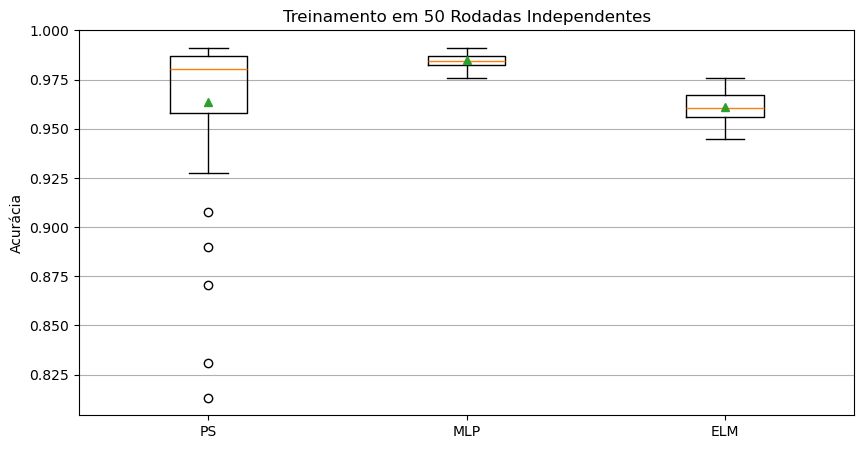

In [ ]:
# Exemplo para um boxplot de acurácia em treino
plt.figure(figsize=(10, 5))

# Cada entrada é uma lista com 50 valores de acurácia
dados_treino = [
    acuracia_treinamento["PS"],
    acuracia_treinamento["MLP"],
    acuracia_treinamento["ELM"]
]

plt.boxplot(dados_treino, tick_labels=["PS", "MLP", "ELM"], showmeans=True)
plt.ylabel("Acurácia")
plt.title("Treinamento em 50 Rodadas Independentes")
plt.grid(axis='y')
plt.show()

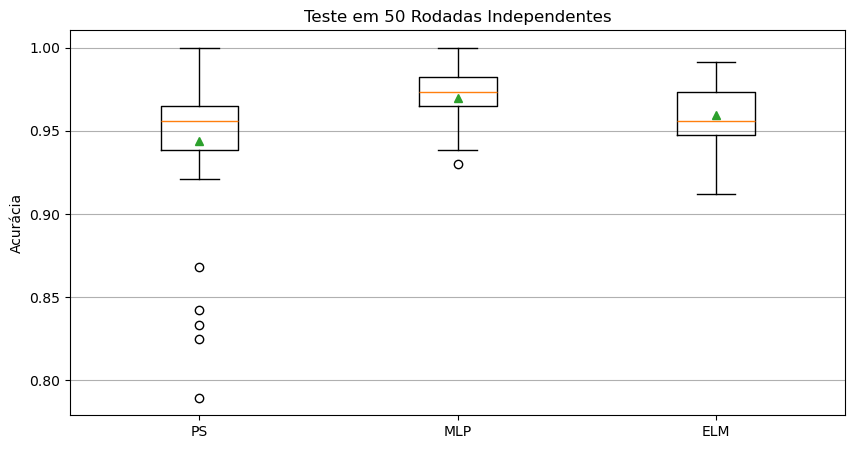

In [ ]:
# Exemplo para um boxplot de acurácia em treino
plt.figure(figsize=(10, 5))

# Cada entrada é uma lista com 50 valores de acurácia
dados_teste = [
    acuracia_teste["PS"],
    acuracia_teste["MLP"],
    acuracia_teste["ELM"]
]

plt.boxplot(dados_teste, tick_labels=["PS", "MLP", "ELM"], showmeans=True)
plt.ylabel("Acurácia")
plt.title("Teste em 50 Rodadas Independentes")
plt.grid(axis='y')
plt.show()

In [10]:
def plot_confusion( matriz_confusão, labels = None, title = "", *, ax = None ):
    confusion = ConfusionMatrixDisplay( 
        matriz_confusão, 
        display_labels = labels 
    )

    confusion.plot(
        colorbar=False,                 # Remove a barra de cores
        values_format=".0f",            # Mostra valores inteiros (sem notação científica),
        text_kw={'color': 'black'},      # Define a cor do texto
        ax = ax
    )

    # Remove os blocos coloridos
    for im in confusion.ax_.get_images():
        im.set_visible(False)

    # Cria uma borda usando retângulos
    for i in range( matriz_confusão.shape[0] ):
        for j in range( matriz_confusão.shape[1] ):
            confusion.ax_.add_patch(
                Rectangle( (j - 0.5, i-0.5), 1, 1, fill=False, edgecolor="black", linewidth=1 )
            )

    # Coloca os labels do eixo X para cima
    confusion.ax_.xaxis.set_ticks_position("top")
    confusion.ax_.xaxis.set_label_position("top")

    # Define o rótulo para os eixos
    confusion.ax_.set_xlabel("Classe Real", labelpad=15)
    confusion.ax_.set_ylabel("Classe Predita", labelpad=15)

    # Seta o título
    ax.set_title( title, pad=15 )


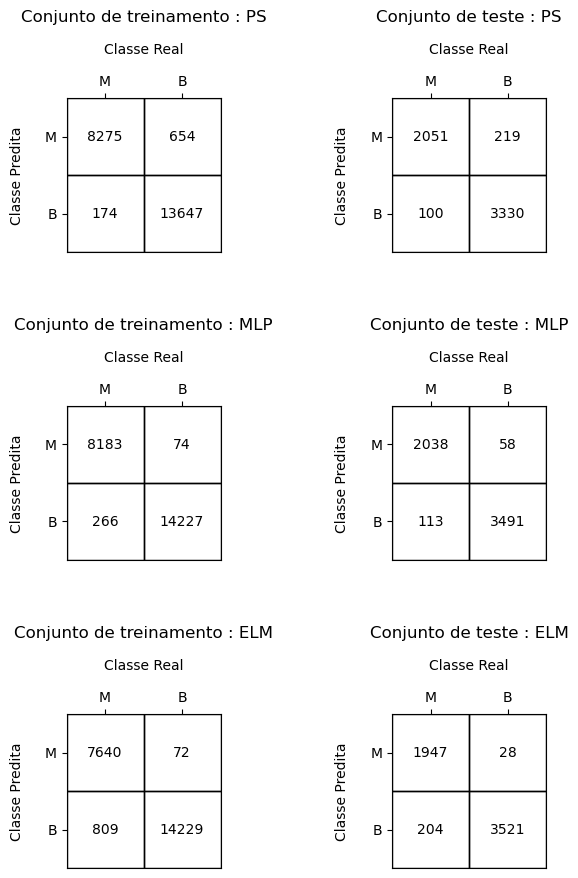

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(7,10))
plt.subplots_adjust(wspace=0.5, hspace=1)

for index, classificador in enumerate(["PS", "MLP", "ELM"]):
    plot_confusion( 
        matriz_confusão_treinamento[classificador], 
        dataset._label_index_to_name.values(),
        f"Conjunto de treinamento : {classificador}",
        ax = axs[index][0]
    )

    plot_confusion( 
        matriz_confusão_teste[classificador], 
        dataset._label_index_to_name.values(),
        f"Conjunto de teste : {classificador}",
        ax = axs[index][1]
    )

### Conjunto de Dados Coluna Vertebral
----

In [12]:
# Conjunto de dados Coluna Vertebral =================================================
colunas = ["pelvic incidence", "pelvic tilt", "lumbar lordosis angle", "sacral slope", "pelvic radius", "degree spondylolisthesis", "class"]

dataset = Dataset.from_file( 
    filepath = r"datasets\column_3C.dat", 
    label_column = -1,
    delimiter = " ",  
    column_names = colunas
).ensure_numeric_labels().normalize()

dataset.vectorize_labels()

print(dataset)

Dataset(instâncias=310, features=6, classes=3)


#### Seleção da taxa de aprendizado e número de épocas

Treinamento encerrado após 500 épocas. Custo = 0.41962263770468444.


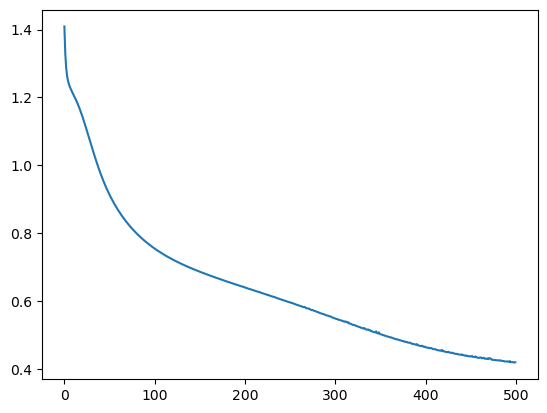

In [ ]:
# MLP
train_dataset, test_dataset = dataset.split()
MLP = MultiLayerPerceptron( train_dataset, q = 3 )

Js = MLP.train( max_epocas = 500, eta = 0.005 )

i, J = zip( *Js )
plt.plot(i, J)

#### Classificação

In [39]:
# Dicionários para armazenar as acurácias
acuracia_teste = {
    "PS": [], "MLP": [], "ELM": []
}

acuracia_treinamento = {
    "PS": [], "MLP": [], "ELM": []
}

# Dicionários com as matrizes de confusão
matriz_confusão_treinamento = {
    "PS":  np.zeros( shape = (dataset.class_count, dataset.class_count) ), 
    "MLP": np.zeros( shape = (dataset.class_count, dataset.class_count) ), 
    "ELM": np.zeros( shape = (dataset.class_count, dataset.class_count) )
}

matriz_confusão_teste = {
    "PS":  np.zeros( shape = (dataset.class_count, dataset.class_count) ), 
    "MLP": np.zeros( shape = (dataset.class_count, dataset.class_count) ), 
    "ELM": np.zeros( shape = (dataset.class_count, dataset.class_count) )
}

In [43]:
# Percorre as rodada independentes
nRodadas = 50

for rodada in range( nRodadas ):
    print(f"\n==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== {rodada+1}/{nRodadas}")

    # Para cada rodada independente, realiza o shuffle e separa o conjunto de dados
    shuffled_dataset = dataset.shuffle()
    train_dataset, test_dataset = shuffled_dataset.split()

    # Cria instâncias para os classificadores
    PS = PerceptronSimples( train_dataset )
    MLP = MultiLayerPerceptron( train_dataset, q = 3 )
    ELM = ExtremeLearningMachine( train_dataset, q = 20 )

    # Treina cada uma das redes
    print("Treinando o PS:")
    PS.train( max_epocas = 200, eta = 0.0001 )

    print("\nTreinando o MLP:")
    MLP.train( max_epocas = 500, eta = 0.005 )

    print("\nTreinando o ELM")
    ELM.train()

    # Reseta os erros em cada rodada
    erros_treinamento = {
        "PS": 0, "MLP": 0, "ELM": 0
    }

    erros_teste = {
        "PS": 0, "MLP": 0, "ELM": 0
    }    

    #  Percorre o conjunto de treinamento e computa os erros
    for index, *features, classe_correta in train_dataset:

        # Preenche os dicionários de erros e as matrizes de confusão
        for nome, classificador in [("PS", PS), ("MLP", MLP), ("ELM", ELM)]:
            classe_predita = classificador.predict( features )
            if classe_predita != classe_correta:
                erros_treinamento[ nome ] += 1
        
            matriz_confusão_treinamento[nome][int(classe_predita)][int(classe_correta)] += 1

    # Percorre o conjunto de teste e computa os erros
    for index, *features, classe_correta in test_dataset:

        # Preenche os dicionários de erros e as matrizes de confusão
        for nome, classificador in [("PS", PS), ("MLP", MLP), ("ELM", ELM)]:
            classe_predita = classificador.predict( features )
            if classe_predita != classe_correta:
                erros_teste[nome] += 1

            matriz_confusão_teste[nome][int(classe_predita)][int(classe_correta)] += 1

    # Armazena a acurácia da rodada
    for classificador in ["PS", "MLP", "ELM"]:
        acuracia_treinamento[classificador].append(
            1 - erros_treinamento[classificador] / len(train_dataset)
        )

        acuracia_teste[classificador].append(
            1 - erros_teste[classificador] / len(test_dataset)
        )

    # Limpa a tela a cada 4 épocas
    if rodada%4 == 0:
        clear_output( wait=False )



==== ==== ==== ==== ==== ==== ==== ==== ==== ==== ==== 50/50
Treinando o PS:
Treinamento encerrado após 200 épocas. Custo = 1.2702158504011565.

Treinando o MLP:
Treinamento encerrado após 500 épocas. Custo = 0.37804060472163775.

Treinando o ELM
Treinamento encerrado. Custo = 0.502836287212515


In [45]:
print("Treinamento: ")
for classificador in ["PS", "MLP", "ELM"]:
    média = np.mean( acuracia_treinamento[classificador] )
    desvio = np.std( acuracia_treinamento[classificador], ddof=0 )

    print(f"{classificador}: {média*100:.2f}%±{desvio*100:.2f}%")

print("\nTeste:")
for classificador in ["PS", "MLP", "ELM"]:
    média = np.mean( acuracia_teste[classificador] )
    desvio = np.std( acuracia_teste[classificador], ddof=0 )

    print(f"{classificador}: {média*100:.2f}%±{desvio*100:.2f}%")


Treinamento: 
PS: 68.58%±6.51%
MLP: 87.33%±1.40%
ELM: 85.62%±1.42%

Teste:
PS: 66.78%±8.35%
MLP: 85.65%±4.09%
ELM: 83.20%±4.22%


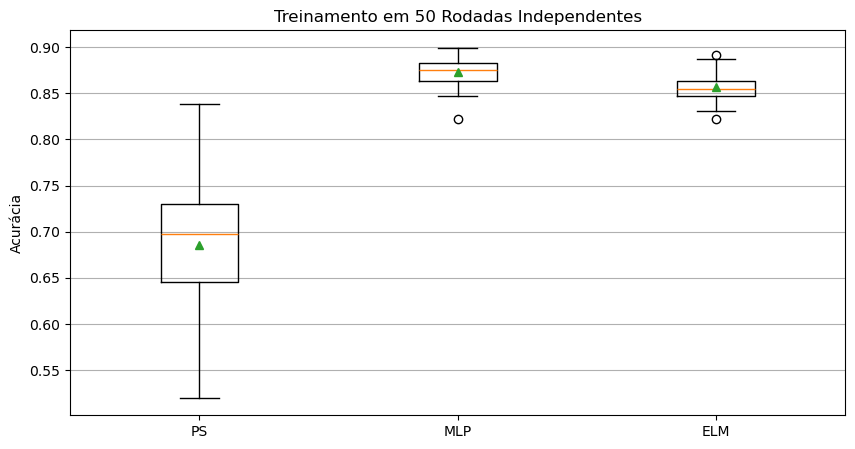

In [46]:
# Exemplo para um boxplot de acurácia em treino
plt.figure(figsize=(10, 5))

# Cada entrada é uma lista com 50 valores de acurácia
dados_treino = [
    acuracia_treinamento["PS"],
    acuracia_treinamento["MLP"],
    acuracia_treinamento["ELM"]
]

plt.boxplot(dados_treino, tick_labels=["PS", "MLP", "ELM"], showmeans=True)
plt.ylabel("Acurácia")
plt.title("Treinamento em 50 Rodadas Independentes")
plt.grid(axis='y')
plt.show()

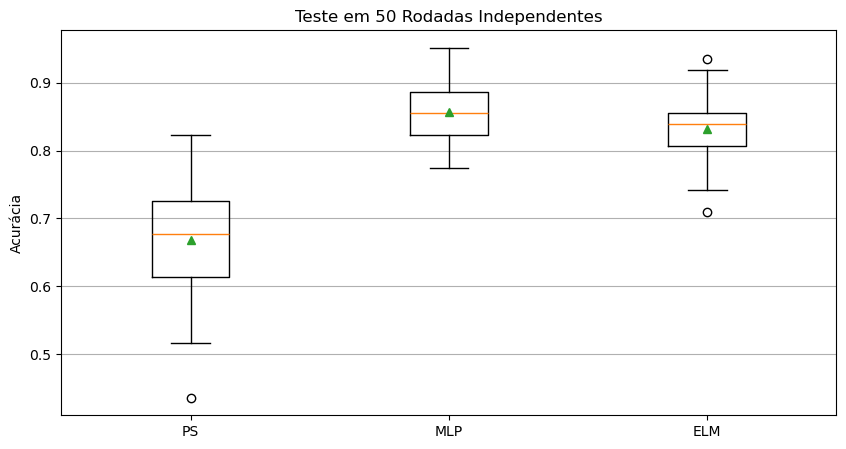

In [47]:
# Exemplo para um boxplot de acurácia em treino
plt.figure(figsize=(10, 5))

# Cada entrada é uma lista com 50 valores de acurácia
dados_teste = [
    acuracia_teste["PS"],
    acuracia_teste["MLP"],
    acuracia_teste["ELM"]
]

plt.boxplot(dados_teste, tick_labels=["PS", "MLP", "ELM"], showmeans=True)
plt.ylabel("Acurácia")
plt.title("Teste em 50 Rodadas Independentes")
plt.grid(axis='y')
plt.show()

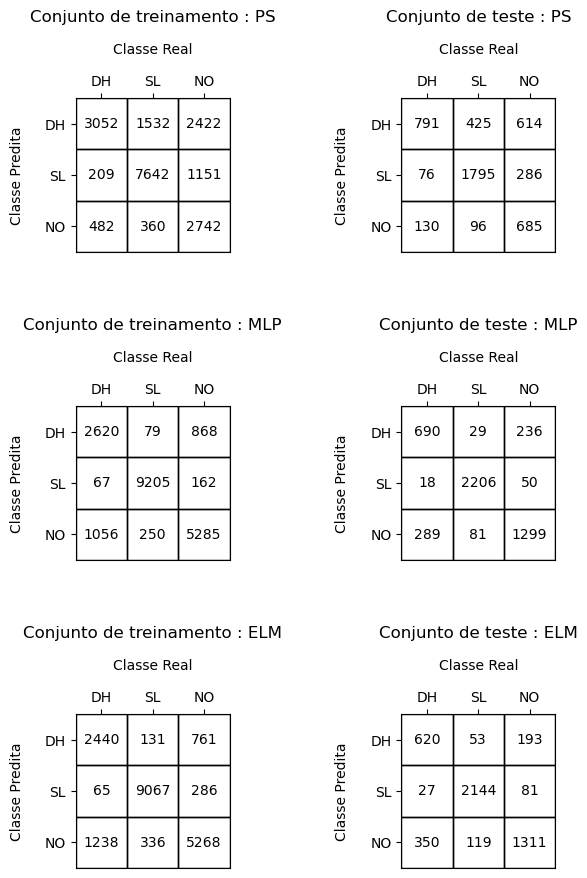

In [48]:
fig, axs = plt.subplots(3, 2, figsize=(7,10))
plt.subplots_adjust(wspace=0.5, hspace=1)

for index, classificador in enumerate(["PS", "MLP", "ELM"]):
    plot_confusion( 
        matriz_confusão_treinamento[classificador], 
        dataset._label_index_to_name.values(),
        f"Conjunto de treinamento : {classificador}",
        ax = axs[index][0]
    )

    plot_confusion( 
        matriz_confusão_teste[classificador], 
        dataset._label_index_to_name.values(),
        f"Conjunto de teste : {classificador}",
        ax = axs[index][1]
    )